# Continuous Control

---

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='banana_app/Banana.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 37
The state for the first agent looks like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [5]:
# Contributions to "Deep Reinforcement Learning Hands-On" by Maxim Lapan
class NoisyLinear(nn.Linear):
    def __init__(self, in_features, out_features, sigma_init=0.017, bias=True):
        super(NoisyLinear, self).__init__(in_features, out_features, bias=bias)
        self.sigma_weight = nn.Parameter(torch.full((out_features, in_features), sigma_init))
        self.register_buffer("epsilon_weight", torch.zeros(out_features, in_features))
        if bias:
            self.sigma_bias = nn.Parameter(torch.full((out_features,), sigma_init))
            self.register_buffer("epsilon_bias", torch.zeros(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        self.weight.data.uniform_(-std, std)
        self.bias.data.uniform_(-std, std)

    def forward(self, input):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self.sigma_bias * self.epsilon_bias.data
        return F.linear(input, self.weight + self.sigma_weight * self.epsilon_weight.data, bias)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, seed, support, n_atoms, state_size = 37, action_size = 4, fc1_units = 64, fc2_units = 64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.n_atoms = n_atoms
        self.fc1 = NoisyLinear(state_size, fc1_units)
        self.fc2 = NoisyLinear(fc1_units, fc2_units)
        self.fc2a = NoisyLinear(fc2_units, 1 * self.n_atoms)
        self.fc3 = NoisyLinear(fc1_units, fc2_units)
        self.fc3a = NoisyLinear(fc2_units, action_size * self.n_atoms)
        self.support = support

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        value = F.relu(self.fc2(x))
        value = self.fc2a(value).view(-1, 1, self.n_atoms)
        advantage = F.relu(self.fc3(x))
        advantage = self.fc3a(advantage).view(-1, action_size, self.n_atoms)
        
        q_atoms = value + advantage - advantage.mean(2).unsqueeze(2)
        q_atoms = F.softmax(q_atoms, dim = 2)
        q_value = torch.sum(q_atoms * self.support, dim = 2)
        return q_value, q_atoms

In [7]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
STEP_SIZE = 3

class Agent():
    def __init__(self, seed, state_size = 37, action_size = 4, buffer_size = BUFFER_SIZE, batch_size = BATCH_SIZE):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.support = torch.linspace(-10, 10, 51)
        self.qnetwork_local = QNetwork(seed, self.support, 51, state_size, action_size)
        self.qnetwork_target = QNetwork(seed, self.support, 51, state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = LR)
        
        self.t_step = 0
        
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.memory_n = deque(maxlen = STEP_SIZE)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names = ["state", "action", "reward", "next_state", "done", "R"])
        self.experience_n = namedtuple("Experience", field_names = ["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def step(self, state, action, reward, next_state, done):
        self.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.sample()
                self.learn(experiences, GAMMA)
    
    def act(self, state):
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0)
        with torch.no_grad():
            action_values, _ = self.qnetwork_local(state)
        return np.argmax(action_values.cpu().data.numpy())
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones, Rs = experiences
        q_value, _ = self.qnetwork_local(torch.FloatTensor(next_states))
        actions_next = torch.argmax(q_value, dim = 1)
        _, q_atoms_next = self.qnetwork_target(torch.FloatTensor(next_states))
        q_atoms_next = q_atoms_next[range(128), actions_next]
        
        tz = torch.clamp(Rs + gamma * self.support * (1 - dones), -10, 10)
        delta_z = (10 + 10) / 50
        b = (tz + 10) / delta_z
        l = b.floor().int()
        u = b.ceil().int()
        m = torch.zeros(q_atoms_next.size()).view(-1)
        
        offset = (torch.linspace(0, (128 - 1) * 51, 128).long().unsqueeze(1).expand(128, 51))
        
        m.index_add_(0, (u + offset).view(-1), (q_atoms_next * (u - b)).view(-1))
        m.index_add_(0, (l + offset).view(-1), (q_atoms_next * (b - l)).view(-1))
        m = m.view(128, 51)
        
        _, q_atom = self.qnetwork_local(torch.FloatTensor(states))
        q_atom = torch.log(q_atom[range(128), actions.squeeze(1)])
        loss = -torch.sum(m * q_atom)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience_n(state, action, reward, next_state, done)
        self.memory_n.append(e)
        
        states = torch.from_numpy(np.vstack([e.state for e in self.memory_n if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in self.memory_n if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in self.memory_n if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in self.memory_n if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in self.memory_n if e is not None]).astype(np.uint8)).float()

        for i in reversed(range(len(states))):
            if i == len(states) - 1:
                R = rewards[i]
            else:
                R = rewards[i] + GAMMA * R
            
        e = self.experience(states[i], actions[i], rewards[i], next_states[len(states) - 1], dones[len(states) - 1], R)
        self.memory.append(e)     
    
    def sample(self):
        experiences = random.sample(self.memory, k = self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        Rs = torch.from_numpy(np.vstack([e.R for e in experiences if e is not None])).float()
        
        return (states, actions, rewards, next_states, dones, Rs)
    
    def __len__(self):
        return len(self.memory)

In [8]:
agent = Agent(seed = 0)

In [9]:
def dqn(n_episodes = 5000, max_t = 1000):
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode = True)[brain_name]
        state = env_info.vector_observations[0] 
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        if i_episode % 5 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_target.state_dict(), 'checkpoint/checkpoint_rainbow_wo_per.pth')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint/checkpoint_rainbow_wo_per.pth')
            break
    return scores

scores = dqn()

Episode 5	Average Score: -0.80
Episode 10	Average Score: -0.40
Episode 15	Average Score: -0.40
Episode 20	Average Score: -0.20
Episode 25	Average Score: -0.08
Episode 30	Average Score: 0.07
Episode 35	Average Score: 0.14
Episode 40	Average Score: 0.07
Episode 45	Average Score: 0.13
Episode 50	Average Score: -0.02
Episode 55	Average Score: 0.13
Episode 60	Average Score: 0.17
Episode 65	Average Score: 0.18
Episode 70	Average Score: 0.14
Episode 75	Average Score: 0.09
Episode 80	Average Score: 0.11
Episode 85	Average Score: 0.19
Episode 90	Average Score: 0.26
Episode 95	Average Score: 0.24
Episode 100	Average Score: 0.28
Episode 105	Average Score: 0.28
Episode 110	Average Score: 0.31
Episode 115	Average Score: 0.38
Episode 120	Average Score: 0.41
Episode 125	Average Score: 0.43
Episode 130	Average Score: 0.45
Episode 135	Average Score: 0.47
Episode 140	Average Score: 0.59
Episode 145	Average Score: 0.73
Episode 150	Average Score: 1.10
Episode 155	Average Score: 1.25
Episode 160	Average Sc

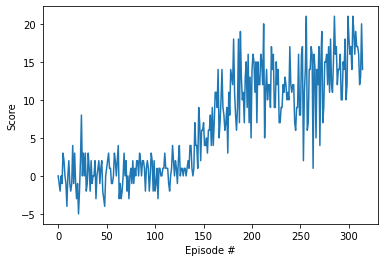

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
env.close()